In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
bank = pd.read_csv('bank-full.csv', delimiter=';')
bank.head()


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [3]:
# будет переиспользована ниже
def find_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (data < lower_bound) | (data > upper_bound)

def remove_outliers(df, column):
    outliers = find_outliers(df[column])
    df_cleaned = df[~outliers]   # инвертируем, чтобы получить значения, которые НЕ являются выбросами
    return df_cleaned

df_cleaned_balance = remove_outliers(bank, 'balance')
df_cleaned_duration = remove_outliers(bank, 'duration')

## 1. Описание датасета

Датасет представляет данные, связанные с телефонными маркетингами звонками португальского банка. \
Датасет создан для решения задачи классификации — предсказать, оформит ли клиент срочный вклад.

Ссылка на датасет: [https://archive.ics.uci.edu/dataset/222/bank+marketing](https://archive.ics.uci.edu/dataset/222/bank+marketing)

Связанное исследование: [A data-driven approach to predict the success of bank telemarketing](https://www.semanticscholar.org/paper/A-data-driven-approach-to-predict-the-success-of-Moro-Cortez/cab86052882d126d43f72108c6cb41b295cc8a9e)


## 2. Описание показаталей

### Подсчеты

In [4]:
results = []

pd.set_option('display.max_colwidth', None)

for col_name in bank.columns:
    col = bank[col_name]
    # Если столбец числовой — считаем его количественным (актуально для данного набора данных)
    if pd.api.types.is_numeric_dtype(col):
        min_val = col.min()
        max_val = col.max()
        mean_val = col.mean()
        range_values = f"{min_val} - {max_val}"
        avg_val = f"{mean_val:.2f}"
    # Если столбец текстовый (качественный)
    else:
        unique_vals = col.unique()
        mode_val = col.mode().values[0]
        range_values = f"{', '.join(map(str, unique_vals))}"
        avg_val = mode_val
    
    results.append([col_name, range_values, avg_val])

results_df = pd.DataFrame(results, columns=["Название", "Диапазон/Уникальные значения", "Среднее значение/Мода"])

results_df

,Название,Диапазон/Уникальные значения,Среднее значение/Мода
0,age,18 - 95,40.94
1,job,"management, technician, entrepreneur, blue-collar, unknown, retired, admin., services, self-employed, unemployed, housemaid, student",blue-collar
2,marital,"married, single, divorced",married
3,education,"tertiary, secondary, unknown, primary",secondary
4,default,"no, yes",no
5,balance,-8019 - 102127,1362.27
6,housing,"yes, no",yes
7,loan,"no, yes",no
8,contact,"unknown, cellular, telephone",cellular
9,day,1 - 31,15.81


### Описание

| Показатель  | Описание                         | Шкала | Тип шкалы  | Диапазон (или уник. значения)                                    | Ср. знач (или мода) |
|-------------|----------------------------------|-----------------|------------|-------------------------------------------------------------------|---------------------|
| age         |   возраст                               | количественная  | интервальная | 18 - 95                                                           | 40.94               |
| job         |          работа                        | качественная    | номинальная | admin, unknown, unemployed, management, housemaid, entrepreneur, student, blue-collar, self-employed, retired, technician, services | blue-collar         |
| marital     |      семейный статус                            | качественная    | номинальная | married, single, divorced                                         | married             |
| education   |        уровень образования                          | качественная    | номинальная (порядковая?) | tertiary, secondary, unknown, primary                             | secondary           |
| default     | есть кредит                      | качественная    | номинальная | no, yes                                                           | no                  |
| balance     | среднегодовой, в евро            | количественная  | абсолютная  | -8019 - 102127                                                    | 1362.27             |
| housing     | кредит на дом                    | качественная    | номинальная | yes, no                                                           | yes                 |
| loan        | потребительский кредит           | качественная    | номинальная | no, yes                                                           | no                  |
| contact     | тип звонка                       | качественная    | номинальная | unknown, cellular, telephone                                      | cellular            |
| day         | день послед. контакта            | количественная  | интервальная | 1 - 31                                                            | 15.81               |
| month       | месяц послед. контакта           | качественная  | номинальная | may, jun, jul, aug, oct, nov, dec, jan, feb, mar, apr             | may                 |
| duration    | длительность послед. контакта    | количественная  | абсолютная  | 0 - 4918                                                          | 258.16              |
| campaign    | кол-во контактов                 | количественная  | абсолютная  | 1 - 63                                                            | 2.76                |

## 3. Визуализация показаталей

### Количественные

#### balance

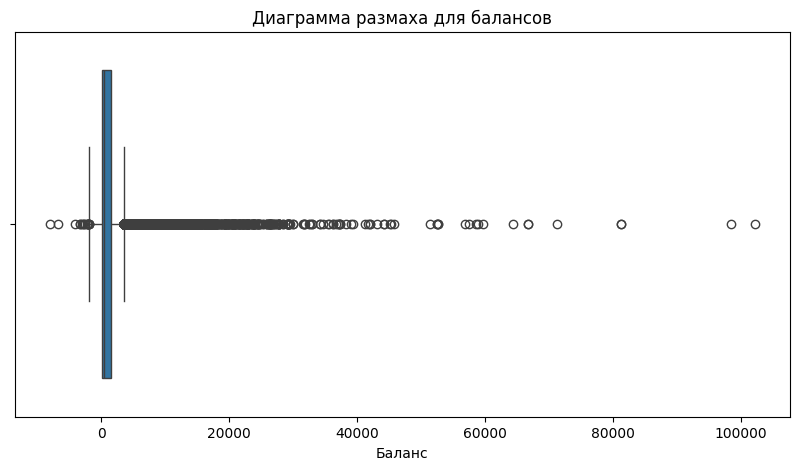

In [5]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=bank['balance'])
plt.title('Диаграмма размаха для балансов')
plt.xlabel('Баланс')
plt.show()


#### day

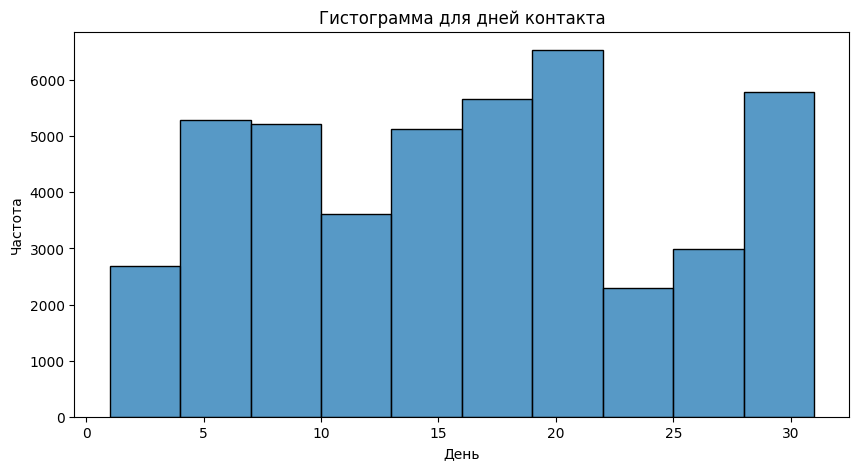

In [6]:
plt.figure(figsize=(10, 5))
sns.histplot(bank['day'], bins=10)
plt.title('Гистограмма для дней контакта')
plt.xlabel('День')
plt.ylabel('Частота')
plt.show()


#### duration

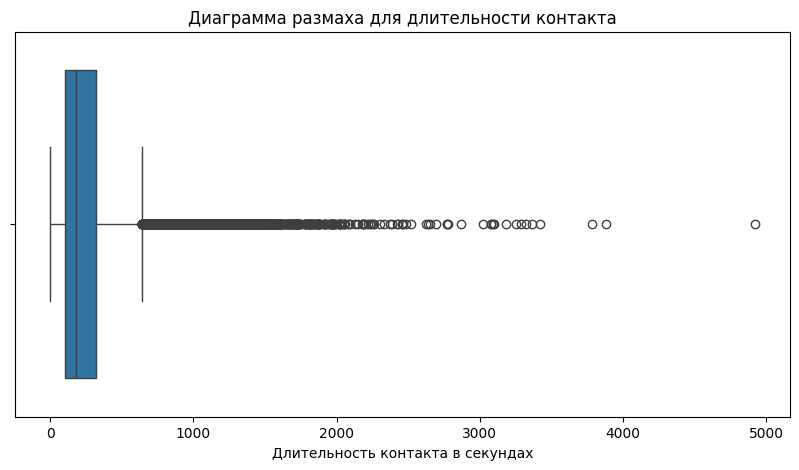

In [7]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=bank['duration'])
plt.title('Диаграмма размаха для длительности контакта')
plt.xlabel('Длительность контакта в секундах')
plt.show()

#### duration (чище)

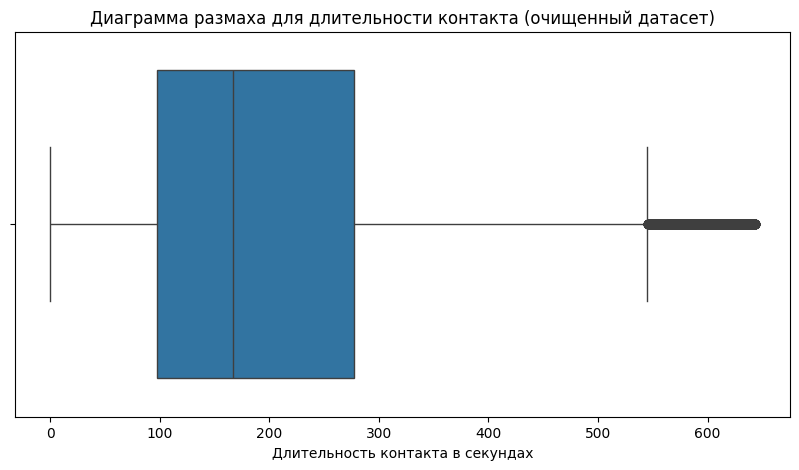

In [8]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=df_cleaned_duration['duration'])
plt.title('Диаграмма размаха для длительности контакта (очищенный датасет)')
plt.xlabel('Длительность контакта в секундах')
plt.show()

### Качественные

#### marital

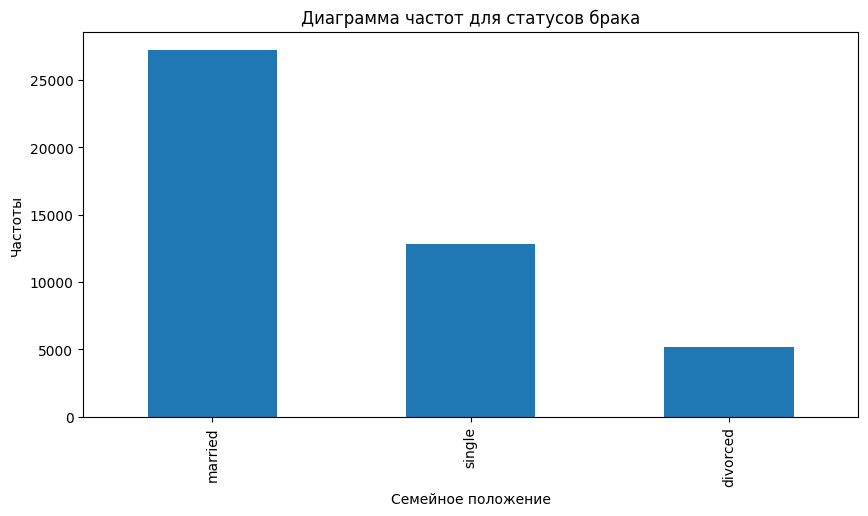

In [9]:
plt.figure(figsize=(10, 5))
bank['marital'].value_counts().plot(kind='bar')
plt.title('Диаграмма частот для статусов брака')
plt.xlabel('Семейное положение')
plt.ylabel('Частоты')
plt.show()

#### education

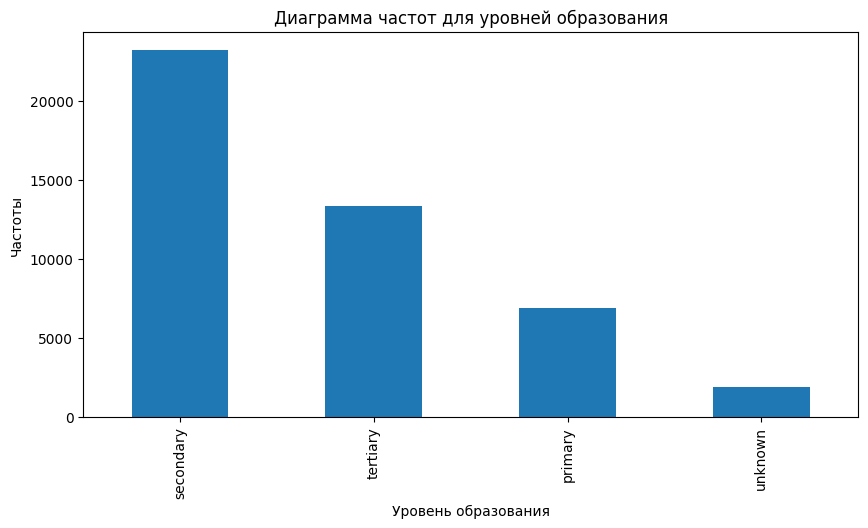

In [10]:
plt.figure(figsize=(10, 5))
bank['education'].value_counts().plot(kind='bar')
plt.title('Диаграмма частот для уровней образования')
plt.xlabel('Уровень образования')
plt.ylabel('Частоты')
plt.show()

#### job

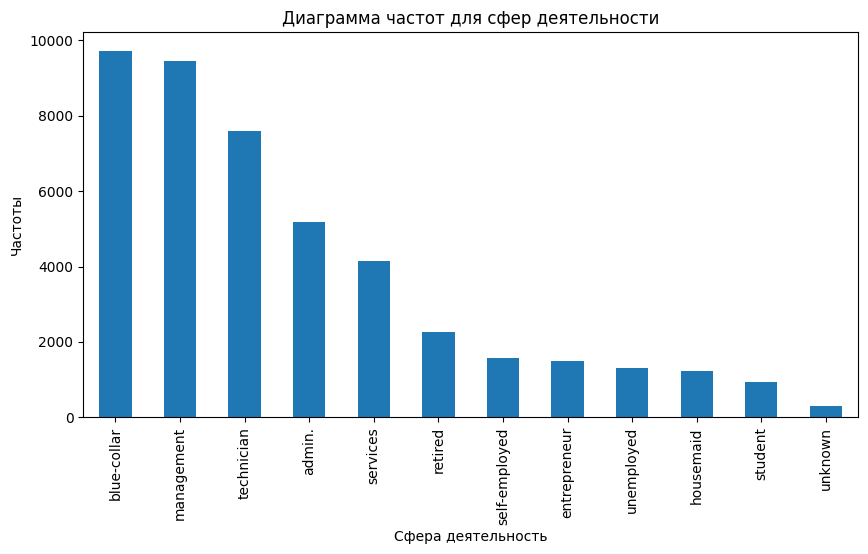

In [11]:
plt.figure(figsize=(10, 5))
bank['job'].value_counts().plot(kind='bar')
plt.title('Диаграмма частот для сфер деятельности')
plt.xlabel('Сфера деятельность')
plt.ylabel('Частоты')
plt.show()

## 4. Группировка объектов

In [12]:
groupped = df_cleaned_balance.groupby('job').agg({
    'age': 'mean',
    'balance': 'mean',
    'duration': 'mean',
    'day': 'mean'
})
groupped

,age,balance,duration,day
job,,,,
admin.,38.977782,591.282480,245.388066,15.548032
blue-collar,39.831192,591.779466,261.653000,15.388895
entrepreneur,41.823970,609.956554,259.395506,15.734831
housemaid,46.387067,624.263206,244.742259,16.032787
management,40.168367,714.955512,251.226988,16.059973
retired,61.159352,862.054336,278.032915,15.445141
self-employed,40.064167,698.174477,267.576063,15.887527
services,38.536560,542.834765,258.094197,15.599011
student,26.463647,735.319428,245.654350,14.842670


### Количественный показатель с наибольшей разницей в средних значениях

In [13]:
# разница в средних значениях (стандартное отклонение)
std_dev = groupped.std()
std_dev

age           7.988307
balance     103.530716
duration     15.390354
day           0.510324
dtype: float64

In [14]:
# ищем показатель, который имеет наибольшую разницу в средних значениях для групп
largest_diff_metric = std_dev.idxmax()
largest_diff_metric


'balance'

<Figure size 1000x600 with 0 Axes>

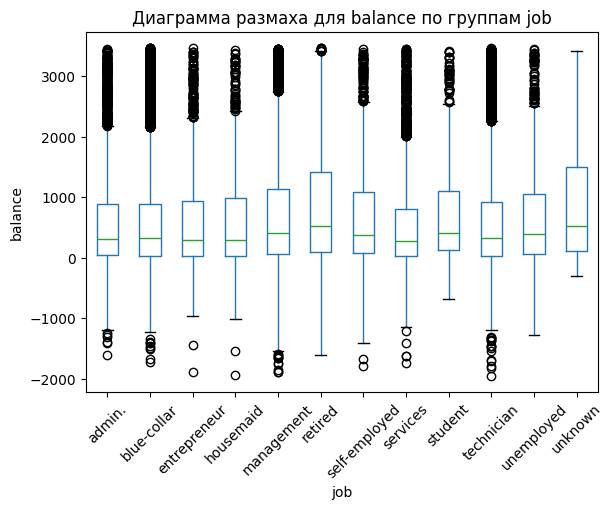

In [15]:
plt.figure(figsize=(10, 6))
df_cleaned_balance.boxplot(column=largest_diff_metric, by='job', grid=False)
plt.title(f'Диаграмма размаха для {largest_diff_metric} по группам job')
plt.suptitle('')  # автоматическое название
plt.xlabel('job')
plt.ylabel(largest_diff_metric)
plt.xticks(rotation=45) # для корректного отображения нижних подписей
plt.show()


### Качественный показатель с наибольшей разницей по частотам значений

In [16]:
# Вычислим частоты значений для каждого качественного показателя в группе 'job'
job_counts = bank['job'].value_counts(normalize=True)
marital_counts = bank.groupby('job')['marital'].value_counts(normalize=True).unstack(fill_value=0)
education_counts = bank.groupby('job')['education'].value_counts(normalize=True).unstack(fill_value=0)

education_counts
# marital_counts

education,primary,secondary,tertiary,unknown
job,,,,
admin.,0.040418,0.815896,0.110617,0.033069
blue-collar,0.386149,0.551891,0.015310,0.046650
entrepreneur,0.123067,0.364492,0.461332,0.051110
housemaid,0.505645,0.318548,0.139516,0.036290
management,0.031085,0.118524,0.824804,0.025587
retired,0.351148,0.434629,0.161661,0.052562
self-employed,0.082331,0.365421,0.527549,0.024699
services,0.083052,0.832210,0.048628,0.036110
student,0.046908,0.541578,0.237740,0.173774


In [17]:
# Вычислим разницы частот между наибольшим и наименьшим значением для каждого качественного показателя
marital_diff = marital_counts.max() - marital_counts.min()
education_diff = education_counts.max() - education_counts.min()

education_diff
# marital_diff

education
primary      0.484847
secondary    0.713686
tertiary     0.809494
unknown      0.418716
dtype: float64

In [18]:
# Найдем качественный показатель с наибольшей разницей в частотах
max_diff_marital = marital_diff.max()
max_diff_education = education_diff.max()

if max_diff_marital > max_diff_education:
    largest_diff_metric = 'marital'
else:
    largest_diff_metric = 'education'

largest_diff_metric

'marital'

## 5. Визуализация зависимостей показателей

### Два количественных (age и balance)

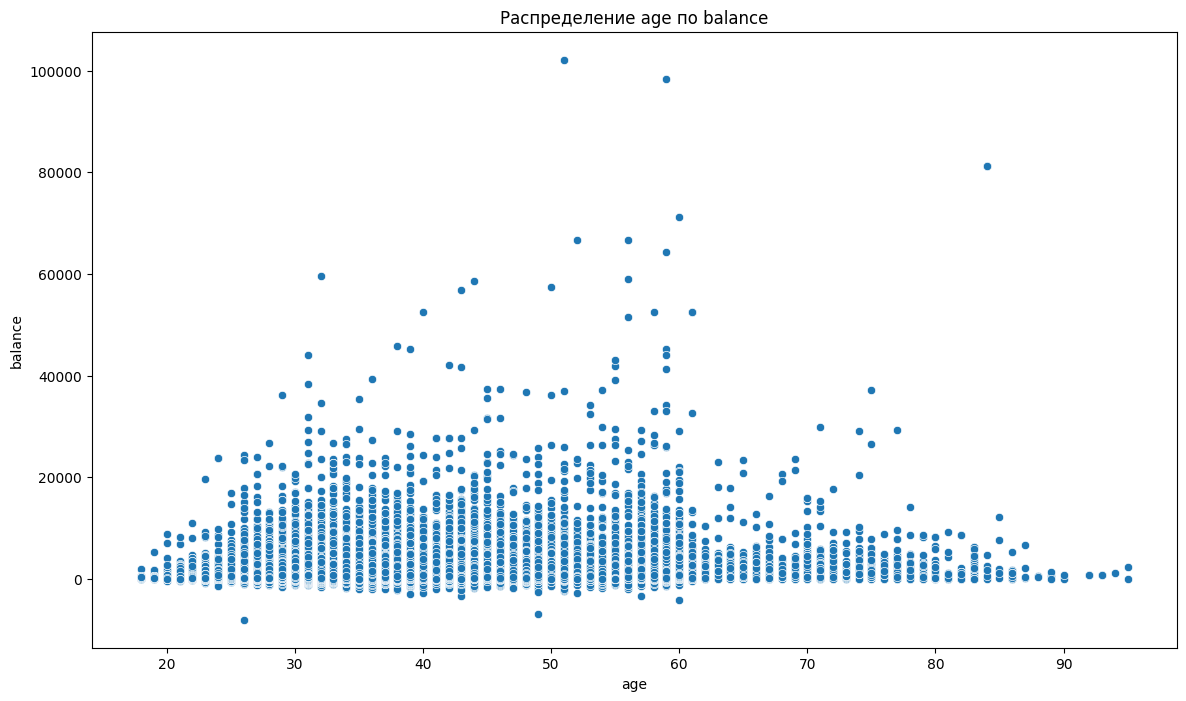

In [20]:
plt.figure(figsize=(14, 8))
sns.scatterplot(x='age', y='balance', data=bank)
plt.title('Распределение age по balance')
plt.xlabel('age')
plt.ylabel('balance')
plt.show()

### Два качественных (education и job)

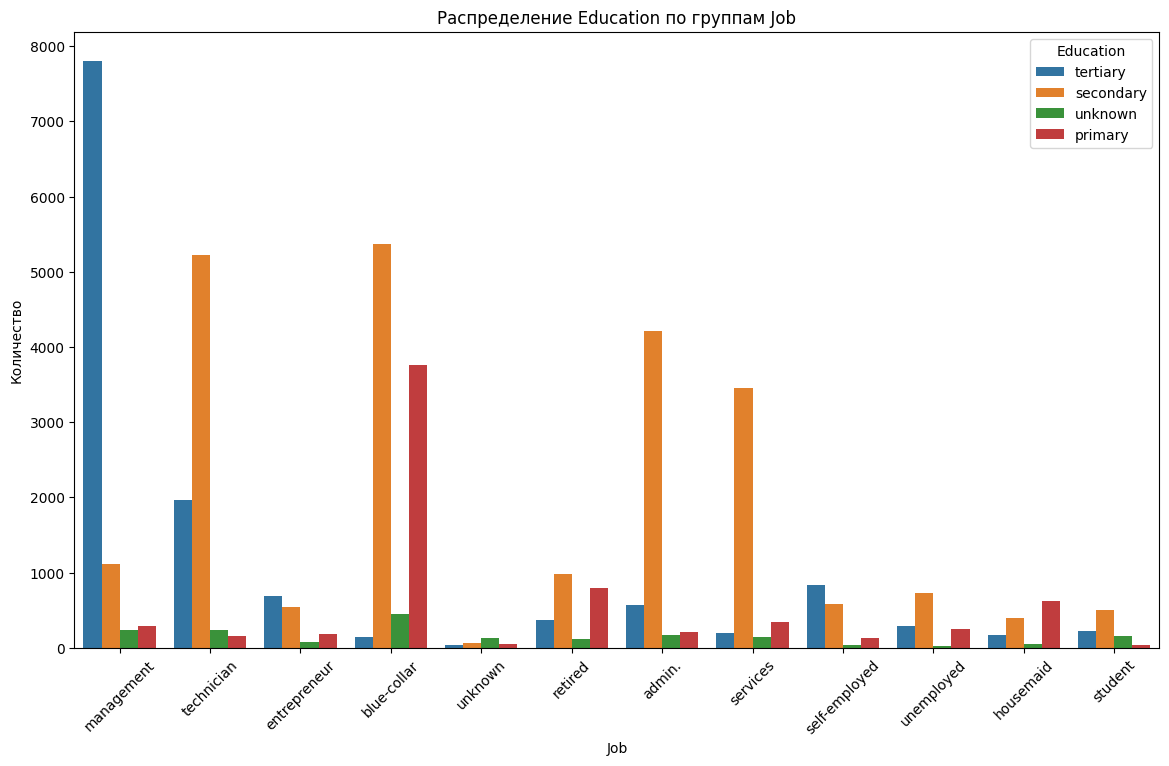

In [21]:
plt.figure(figsize=(14, 8))
sns.countplot(x='job', hue='education', data=bank)
plt.title('Распределение Education по группам Job')
plt.xlabel('Job')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.legend(title='Education')
plt.show()

### Количественный + качественный (age и marital)

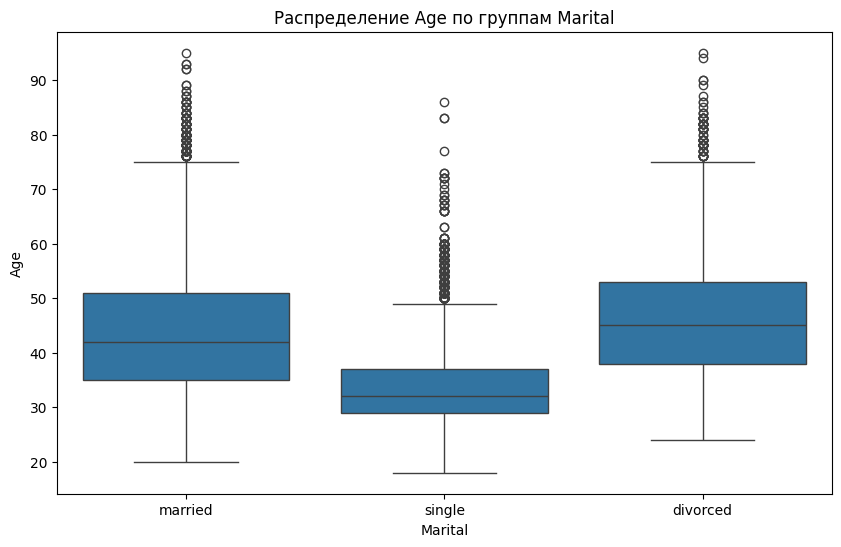

In [22]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='marital', y='age', data=bank)
plt.title('Распределение Age по группам Marital')
plt.xlabel('Marital')
plt.ylabel('Age')
plt.show()

## 6. Пропуски данных и аномальные выбросы

### Ищем выбросы

In [23]:
quantitative_columns = ['age', 'balance', 'day', 'duration', 'campaign']

for column in quantitative_columns:
    outliers = find_outliers(bank[column]) # определена в начале
    num_outliers = np.sum(outliers)
    print(f"{column}: {num_outliers} выбросов")

age: 487 выбросов
balance: 4729 выбросов
day: 0 выбросов
duration: 3235 выбросов
campaign: 3064 выбросов


### Ищем пропуски

In [24]:
def check_spaces(data):
    at_least_one = False
    for column in data.columns:
        spaces = data[column] == 'unknown'
        num_spaces = np.sum(spaces)
        if (num_spaces > 0):
            print(f"{column}: {num_spaces} пропусков")
            at_least_one = True
    if (not at_least_one):
        print("Нет пропусков в датасете")
        
check_spaces(bank)

job: 288 пропусков
education: 1857 пропусков
contact: 13020 пропусков
poutcome: 36959 пропусков


### Устраняем пропуски

#### Удаляем строки

In [25]:
df_cleaned = bank.replace('unknown', np.nan).dropna()
check_spaces(df_cleaned)

Нет пропусков в датасете


#### Заменяем на моду

In [26]:
df_filled = bank.replace('unknown', np.nan)

for col in df_filled.columns:
    if df_filled[col].dtype == 'object':
        df_filled[col] = df_filled[col].fillna(df_filled[col].mode()[0])

check_spaces(df_filled)

Нет пропусков в датасете
